In [1]:
#pip install torchsummary

In [52]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# For mutliple devices (GPUs: 4, 5, 6, 7)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [1]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import random



In [2]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [3]:
#Dataset
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [4]:
#MetaDataset MNIST or Custom Dataset
dataset = l2l.data.MetaDataset(dataset)
ways = 10
shots = 1
transforms = [
    NWays(dataset, n=ways),
    KShots(dataset, k=shots),
    LoadData(dataset),
]
tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# MetaDataset Sampling
for task in tasksets:
    X, y = task
    print(y)

tensor([8, 1, 2, 7, 5, 9, 0, 4, 6, 3])
tensor([6, 7, 2, 0, 1, 4, 3, 9, 8, 5])
tensor([9, 3, 7, 0, 1, 5, 2, 4, 6, 8])
tensor([9, 4, 5, 1, 0, 7, 6, 3, 2, 8])
tensor([5, 0, 7, 8, 9, 4, 1, 3, 6, 2])


In [4]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
#             "mini-imagenet", 
#             "fc100", "cifarfs", "tiered-imagenet"
ways = 4
shots = 5

# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                             )

Files already downloaded and verified
Files already downloaded and verified


X.size: torch.Size([40, 1, 28, 28])
torch.Size([40, 1, 28, 28])
Train: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


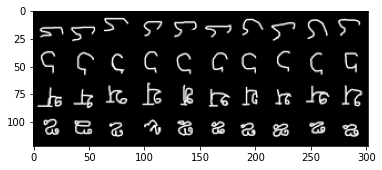

In [5]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
print(X.shape)
# print(X[0])
X.to(device)
# print(X[0])
print("Train:", y)
grid = utils.make_grid(X, nrow=shots *2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [54]:
# Separate data into adaptation/evalutation sets
adaptation_indices = np.zeros(X.size(0), dtype=bool)
adaptation_indices[np.arange(shots*ways) * 2] = True
evaluation_indices = torch.from_numpy(~adaptation_indices)
adaptation_indices = torch.from_numpy(adaptation_indices)

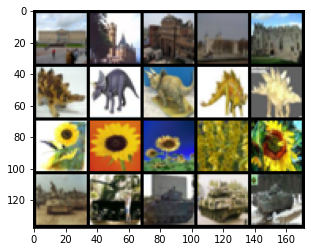

In [55]:
#Adaptation Data
grid = utils.make_grid(X[adaptation_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

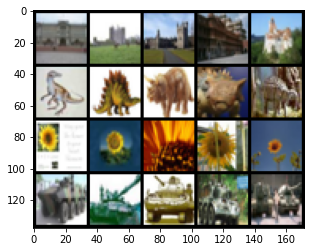

In [56]:
#Adaptation Data
grid = utils.make_grid(X[evaluation_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


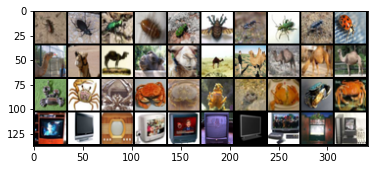

In [57]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


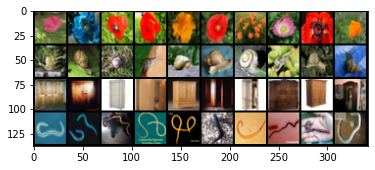

In [60]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [12]:
class default_weight_args:
    def __init__(self):
        super(default_weight_args, self).__init__()
        self.fc_input_mean_mu = 0
        self.fc_input_mean_sigma = 0.1
        self.fc_input_mean_bias = 0.0001
        self.fc_input_sigma_min = -12
        self.fc_input_sigma_max = -2.2
        self.fc_input_sigma_bias = 0.0001
        self.conv_input_mean_mu = 0
        self.conv_input_mean_sigma = 0.1
        self.conv_input_mean_bias = 0.0001
        self.conv_input_sigma_min = -12
        self.conv_input_sigma_max = -2.2
        self.conv_input_sigma_bias = 0.0001


global_layer_default = default_weight_args()

class VDP_FullyConnected(nn.Module):
    """
    This class is for the instance creation of an Variational Density Propagation Fully Connected
    Layer. This class contains the function :func:`__init__` for the initialization of the instance,
    the function :func:`forward` for the forward propagation through the layer when called, and
    the last function :func:`kl_loss_term` which is called in the loss function as part of the
    regularization of the network.
    """

    def __init__(self, in_features, out_features, bias=True, weight_args=global_layer_default,
                 input_flag=False):
        """
        :param in_features:     (Required)
        :param out_features:    (Required)
        :param bias:            (Default  True)
        :param mean_mu:         (Default  0)
        :param mean_sigma:      (Default  0.1)
        :param sigma_min:       (Default -12)
        :param sigma_max:       (Default -2.2)
        :param mean_bias:       (Default  0.001)
        :param sigma_bias:      (Default  0.001)
        :param input_flag:      (Default  False)
        """
        super(VDP_FullyConnected, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.input_flag = input_flag

        self.mean = nn.Linear(in_features, out_features, bias)
        nn.init.normal_(self.mean.weight, mean=weight_args.fc_input_mean_mu, std=weight_args.fc_input_mean_sigma)
        self.mean.bias.data.fill_(weight_args.fc_input_mean_bias)

        self.sigma_weight = nn.Parameter(torch.zeros([1, out_features]), requires_grad=True)
        nn.init.uniform_(self.sigma_weight, a=weight_args.fc_input_sigma_min, b=weight_args.fc_input_sigma_max)
        self.sigma_bias = nn.Parameter(torch.ones([out_features]) * self.bias, requires_grad=True)

    def forward(self, mu, sigma=0):
        """
        Forward pass over the VDP 2D Fully Connected Layer

        :param mu:      Data Mean     (Required)
        :type  mu:      Float
        :param sigma:   Data Sigma    (Required if input_flag=False)
        :type  sigma:   Float
        """
        if self.input_flag:
            # Input Version
            mu_f = self.mean(mu)

            mu_pT_mu_p = torch.matmul(mu.unsqueeze(1), mu.unsqueeze(2)).squeeze(1)
            if self.bias:
                sigma_1 = torch.log1p(torch.exp(self.sigma_weight)).repeat(mu.shape[0], 1) * mu_pT_mu_p.repeat(1, self.out_features)
            else:
                sigma_1 = torch.log1p(torch.exp(self.sigma_weight)).repeat(mu.shape[0], 1) * mu_pT_mu_p.repeat(1, self.out_features)

            sigma_out = torch.diag_embed(sigma_1, dim1=1) + torch.diag(self.sigma_bias)

        else:
            # Mu Weight * Mu in
            mu_f = self.mean(mu)

            # Mean Weight^2 * sigma in
            muh_w = self.mean.weight.unsqueeze(0)
            muhT_sigmab_mu = torch.matmul(torch.matmul(muh_w, sigma), muh_w.permute([0, 2, 1]))

            tr_diag_sigma = torch.diagonal(sigma, dim1=1, dim2=2).sum(1).unsqueeze(1)

            mu_pT_mu_p = torch.matmul(mu.unsqueeze(1), mu.unsqueeze(2)).squeeze(1)

            # tr(Sigma Weights * Sigma In)
            # Mu in ^2 * Sigma Weights
            if self.bias:
                sigma_weight_out = torch.log1p(torch.exp(self.sigma_weight)).repeat(mu.shape[0], 1) * (tr_diag_sigma.repeat(1, self.out_features) + mu_pT_mu_p.repeat(1, self.out_features))
            else:
                sigma_weight_out = torch.log1p(torch.exp(self.sigma_weight)).repeat(mu.shape[0], 1) * (tr_diag_sigma.repeat(1, self.out_features) + mu_pT_mu_p.repeat(1, self.out_features))

            diag_sigma_weight_out = torch.diag_embed(sigma_weight_out, dim1=1)

            # tr(Sigma Weights * Sigma In) + Mean Weight^2 * sigma in + Mu in ^2 * Sigma Weights
            sigma_out = muhT_sigmab_mu + diag_sigma_weight_out + torch.diag(self.sigma_bias)

        return mu_f, sigma_out

    def kl_loss_term(self):
        """
        KL Loss term for the loss function
        """
        f_s = torch.log1p(torch.exp(self.sigma_weight))

        kl_loss = -0.5 * torch.mean((self.in_features * torch.log(f_s)) +
                                      self.in_features -
                                      torch.norm(self.mean.weight)**2 -
                                      (self.in_features * f_s))
        return kl_loss


class VDP_Softmax(nn.Module):
    """
    This class is for the instance creation of an Variational Density Propagation Softmax Activation.
    This class contains the function :func:`__init__` for the initialization of the instance
    and the function :func:`forward` for the forward propagation through the layer when called
    """

    def __init__(self, dim=1):
        """
        :param dim:     (Default  1)
        """
        super(VDP_Softmax, self).__init__()
        self.softmax = nn.Softmax(dim)

    def forward(self, mu, sigma):
        """
        Forward pass over the VDP 2D Softmax Layer

        :param mu:      Data Mean     (Required)
        :type  mu:      Float
        :param sigma:   Data Sigma    (Required)
        :type  sigma:   Float
        """
        mu_y = self.softmax(mu)

        grad_f1 = torch.bmm(mu_y.unsqueeze(2), mu_y.unsqueeze(1))
        diag_f = torch.diag_embed(mu_y, dim1=1)
        grad_soft = diag_f - grad_f1
        sigma_y = torch.matmul(grad_soft, torch.matmul(sigma, grad_soft.permute(0, 2, 1)))
        return mu_y, sigma_y
    


In [45]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [84]:
from torchsummary import torchsummary
class VDP_MAML(nn.Module):
    def __init__(self, ways):
        super(VDP_MAML, self).__init__()
        self.tau = 0.002
        self.clamp = 1000
        self.var_sup = 0.001
        self.model = resnet18(pretrained=True).to(device)
        for param in model.parameters():
            param.requires_grad = False
        #     print(param.name)
#         self.model.fc = nn.Linear(num_ftrs, ways).to(device)
        self.vdp_input_fc = VDP_FullyConnected(in_features=self.model.fc.in_features, out_features=64,
                                        input_flag=True).to(device)
        self.vdp_fc = VDP_FullyConnected(in_features=64, out_features=ways,
                                        input_flag=False).to(device)
        self.model.fc = Identity()#
#         torchsummary.summary(self.model, input_size= (3, 64, 64))
        self.vdp_softmax = VDP_Softmax(1).to(device)
    
    def forward(self, x):
        x = self.model(x)
#         print("X:", x.shape)
        mean, sigma = self.vdp_input_fc(x)
        mean, sigma = self.vdp_fc(mu=mean, sigma=sigma)
        mean, sigma = self.vdp_softmax(mean, sigma)
        
        return mean, sigma
    
    def nll_gaussian(self, y_pred_mean, y_pred_sd, y_test):
        NS = torch.diag(
            torch.ones(list(self.children())[-2].out_features, device=y_pred_sd.device) * torch.tensor(self.var_sup,
                                                                                                       device=y_pred_sd.device))
        y_pred_sd_inv = torch.inverse(y_pred_sd + NS)
        mu_ = y_pred_mean - y_test
        mu_sigma = torch.bmm(mu_.unsqueeze(1), y_pred_sd_inv)
        ms = (torch.bmm(mu_sigma, mu_.unsqueeze(2)).squeeze(1) +
              (torch.slogdet(y_pred_sd + NS)[1]).unsqueeze(1)).mean()
        return ms

    def batch_loss(self, output_mean, output_sigma, label):
        output_sigma_clamp = torch.clamp(output_sigma, -self.clamp, self.clamp)
        neg_log_likelihood = self.nll_gaussian(output_mean, output_sigma_clamp, label)
        loss_value = neg_log_likelihood + (self.tau * self.vdp_input_fc.kl_loss_term() +
                                           self.tau * self.vdp_fc.kl_loss_term())
        return loss_value

In [85]:
# print(VDP_MAML(ways=5)(torch.rand((1,3,64,64)).to(device)))
mean, sigma = VDP_MAML(ways=5)(torch.rand((1,3,64,64)).to(device))
print("Mean:", mean)
print("Sigma:", sigma.shape)
model = VDP_MAML(ways=5)

Mean: tensor([[0.1086, 0.0008, 0.3191, 0.1524, 0.4191]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
Sigma: torch.Size([1, 5, 5])


In [89]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=100)
samples = 10
for i_ep in range(10):
    total_loss = 0
    total_acc = 0
    total_num = 0
    model.train()
#     print('| Epoch {:3d}, '.format(i_ep+prev_epoch), end='')
    for idx, (data, targets) in enumerate(train_loader):
        optim.zero_grad()
        data, targets = data.to(args.devices), targets.to(args.devices)

        output = model(data, sample=False)
        _, pred = output.max(1, keepdim=True)

        lps, lvps, predictions = [], [], []
        for i in range(10):
            predictions.append(model(data))
            lp, lv = logs(model)
            lps.append(lp)
            lvps.append(lv)

        loss = model.batch_loss(predictions, lps, lvps, len(train_loader), targets)

        total_loss += loss.detach().cpu().numpy()
        total_acc += pred.eq(targets.view_as(pred)).sum().item()
        total_num += len(targets)

        loss.backward(retain_graph=True)
        optim.step()

    train_loss = total_loss / total_num
    train_acc = total_acc / total_num

    print(' | Train: loss={:8.4f}, acc={:5.1f}% | '.format(np.round(train_loss, 4), 100 * train_acc), end='')

    valid_loss, valid_acc = eval(args, model, test_loader)
    print('Valid: acc={:5.1f}% | '.format(100 * valid_acc), end='')

    print('')

NameError: name 'train_loader' is not defined

In [7]:
from torchsummary import torchsummary
model = resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
#     print(param.name)
num_ftrs = model.fc.in_features

num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)
# model.fc = VDP_Softmax(VDP_FullyConnected(in_features=num_ftrs, out_features=ways)).to(device)
mean, sigma = VDP_FullyConnected(in_features=num_ftrs, out_features=ways)
fc1 = VDP_Softmax()
model.fc = VDP_Softmax(VDP_FullyConnected(in_features=num_ftrs, out_features=ways)).to(device)
# mu, sigma = self.softmax.forward(mu, sigma)

print(model(torch.rand((1,3,64,64)).to(device)))
# torchsummary.summary(model, input_size= (3, 64, 64))

NameError: name 'VDP_FullyConnected' is not defined

In [155]:
from learn2learn.algorithms.base_learner import BaseLearner

class MetaLearner(nn.Module):
    meta_model = None
    meta_optimizer = 0
    def __init__(self, meta_model, meta_optimizer):
        super(MetaLearner, self).__init__()
        MetaLearner.meta_model = model
        MetaLearner.meta_optimizer = meta_optimizer
        
#     def forward(self, *args, **kwargs):
#         return self.module(*args, **kwargs)
    
    def adapt():
        print("Not applicable to Metalearner")
        
    def clone():
        print("Not applicable to Metalearner")
    
    
class MAML(MetaLearner):
    def __init__(self, model, meta_optimizer):
        super(MAML, self).__init__()
#         print("Constructor")
#         self.model = model
    
    def adapt(self):
        super.adapt(self)
        print("Adapted")
        
    def clone(self):
        super.clone(self)
        print("Cloned")

meta_model = nn.Linear(in_features=10, out_features=2, bias=True)
meta_optimizer = optim.SGD(meta_model.parameters(), lr=0.001)

meta_learner = MAML(meta_model=nn.Module(), meta_optimizer=None)
# adapted_learner = AdaptedLeaner()
# print(maml.adapt)

TypeError: __init__() got an unexpected keyword argument 'meta_model'

In [95]:
class Base(nn.Module):
    num = 0
    def __init__(self):
        super(Base, self).__init__()
        print("Base constructor")
        Base.num = -10
        
    def increment(self):
        print("increment")
        Base.num += 1
        
    def baseUpdate(self):
        print("BaseUpdate")
    
    def adapt(self):
        print("Not applicable to base")
    
    def count(self):
        print("Num Count:", self.num)
    
    
class Adapted(Base):
    def __init__(self):
        super(Adapted, self).__init__()
        print("Adapted contructor")
        Base.increment(self)
    
    def baseUpdate(self):
        Base.baseUpdate(self)
        print("Adapted calling base method")
    
    def adapt(self):
        Base.adapt(self)
        print("Adapt parameters here")
    
        
base = Base()
base.count()
adapt = Adapted()
adapt = Adapted()
adapt = Adapted()
adapt.count()

Base constructor
Num Count: -10
Base constructor
Adapted contructor
increment
Base constructor
Adapted contructor
increment
Base constructor
Adapted contructor
increment
Num Count: -9


In [96]:
base.baseUpdate()
base.adapt()

BaseUpdate
Not applicable to base


In [97]:
adapt.baseUpdate()

BaseUpdate
Adapted calling base method


In [98]:
adapt.adapt()

Not applicable to base
Adapt parameters here


In [136]:
## Internal Parameters
class Param(nn.Module):
#     T = torch.rand((2,2), requires_grad=True)
#     P1 = nn.Parameter(torch.tensor(0.55, requires_grad=True))
#     P2 = nn.Parameter(torch.tensor([[0,0],[1,1]], requires_grad=True, dtype=torch.float32))
    def __init__(self):
        super(Param,self).__init__()
        print("Constructed")
        self.PP = nn.Parameter(torch.tensor(0.5), requires_grad=False)
        self.PP.data = torch.FloatTensor([3232])
        self.PP2 = nn.Parameter(torch.tensor([[0,0],[1,1]], requires_grad=True, dtype=torch.float32))
        self.PP2.data = torch.FloatTensor([54321])
        
# p = Param()    
# print(p.PP)
# print(p.P)
print(list(Param().parameters()))
# print((Param.P))


Constructed
[Parameter containing:
tensor([3232.]), Parameter containing:
tensor([54321.], requires_grad=True)]


In [8]:
print([p for p in Param().parameters() if p.requires_grad])

Constructed
[Parameter containing:
tensor([[0., 0.],
        [1., 1.]], requires_grad=True)]


In [10]:
print(dict(Param().named_parameters()))

Constructed
{'PP': Parameter containing:
tensor(0.5000), 'PP2': Parameter containing:
tensor([[0., 0.],
        [1., 1.]], requires_grad=True)}


In [11]:
print(list(Param().parameters()))

Constructed
[Parameter containing:
tensor(0.5000), Parameter containing:
tensor([[0., 0.],
        [1., 1.]], requires_grad=True)]


In [13]:
print(dict(Param().named_parameters()).keys())

Constructed
dict_keys(['PP', 'PP2'])


In [24]:
print(dict(model.named_parameters()).keys())

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 

In [147]:
dc_model = copy.deepcopy(model)

In [148]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [151]:
dc_model = copy.deepcopy(model)
nmbr_f = dc_model.fc.in_features
dc_model.fc = nn.Linear(num_ftrs, 10)

In [153]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
import copy
#DeepCopy
model = nn.Linear(1, 1)
model_deep_copy = copy.deepcopy(model)
# print(type(model.weight))
model.weight.data = torch.FloatTensor([121])

print("*" * 50)
print("Model:", dict(model.named_parameters()))
print("*" * 50)
print("DeepModel:", dict(model_deep_copy.named_parameters()))
print("*" * 50)

#We can only copy the leaf tensors (Created by us). We cannot copy the non-leaf tensor.
leaf_tensor = nn.Parameter(data=torch.FloatTensor([0.1]), requires_grad=True)
print("Leaf Tensor:", leaf_tensor)
y = leaf_tensor * 2
print("Y:", y)
print("Leaf Deep Copy:", copy.deepcopy(leaf_tensor))
print("Non-Leaf Deep Copy (Error):", copy.deepcopy(y))


**************************************************
Model: {'weight': Parameter containing:
tensor([121.], requires_grad=True), 'bias': Parameter containing:
tensor([-0.0994], requires_grad=True)}
**************************************************
DeepModel: {'weight': Parameter containing:
tensor([[-0.6039]], requires_grad=True), 'bias': Parameter containing:
tensor([-0.0994], requires_grad=True)}
**************************************************
Leaf Tensor: Parameter containing:
tensor([0.1000], requires_grad=True)
Y: tensor([0.2000], grad_fn=<MulBackward0>)
Leaf Deep Copy: Parameter containing:
tensor([0.1000], requires_grad=True)


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [82]:
# with torch.no_grad():
model.weight.data.fill_ = torch.tensor(0)
print(model.weight.data)
# model.weight


tensor([[0.9940]])


In [74]:
print(dict(model.named_parameters()))

{'weight': Parameter containing:
tensor([[0.9940]], requires_grad=True), 'bias': Parameter containing:
tensor([-0.8616], requires_grad=True)}


In [131]:
import torch
from torch.autograd import Variable

def basic_fun(x):
    return 3*(x*x)

def get_grad(x):
    A = basic_fun(x)
    A.backward()
    return x.grad

x = Variable(torch.FloatTensor([3]), requires_grad=True)
# xx = copy.deepcopy(x)
# xx = x.clone()
xx = Variable(x.data.clone(), requires_grad=True)

x.data = torch.FloatTensor([4])
xx.data = torch.FloatTensor([2])

print("x.Data", x.data)
print("xx.Data", xx.data)

print(basic_fun(x))
print("G:", get_grad(x))
print("D-Copy: G:", get_grad(xx))


x.Data tensor([4.])
xx.Data tensor([2.])
tensor([48.], grad_fn=<MulBackward0>)
G: tensor([24.])
D-Copy: G: tensor([12.])


In [120]:
# Grad wrt x will work
print(x.creator is None) # is it a leaf? Yes
# print(get_grad(x, x))
# print(get_grad(xx, x))

# # Grad wrt xx won't work
# print(xx.creator is None) # is it a leaf? No
# print(get_grad(xx, xx))
# print(get_grad(x, xx))

AttributeError: 'Tensor' object has no attribute 'creator'

In [5]:
from torchsummary import torchsummary
model = resnet18(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
#     print(param.name)
num_ftrs = model.fc.in_features

num_ftrs 
model.fc = nn.Linear(num_ftrs, 10).to(device)
# model.fc = VDP_Softmax(VDP_FullyConnected(in_features=num_ftrs, out_features=ways)).to(device)
# mean, sigma = VDP_FullyConnected(in_features=num_ftrs, out_features=ways)
# fc1 = VDP_Softmax()
# model.fc = VDP_Softmax(VDP_FullyConnected(in_features=num_ftrs, out_features=ways)).to(device)
# mu, sigma = self.softmax.forward(mu, sigma)


torchsummary.summary(model, input_size= (3, 64, 64))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [6]:
rand_img = torch.rand(1,3,64,64).to(device)
print(model(rand_img))

tensor([[-0.4549,  0.5001,  1.0075, -0.9307, -0.0329, -0.0919,  0.3421,  0.0363,
          0.3511,  0.2345]], device='cuda:0', grad_fn=<AddmmBackward>)


In [8]:
import copy
deep_copy = copy.deepcopy(model)
torchsummary.summary(model, input_size= (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [9]:
print(deep_copy(rand_img))

for param in deep_copy.parameters():
    param.requires_grad = False
    print(param.shape)
    break

tensor([[-0.4549,  0.5001,  1.0075, -0.9307, -0.0329, -0.0919,  0.3421,  0.0363,
          0.3511,  0.2345]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([64, 3, 7, 7])


# Copying the weights of the networks

In [11]:
print(model.layer1[0].conv1)
print(model.layer1[0].conv1.weight.shape)
print(model.fc)
print(model.fc.weight.shape)
print(model.fc.weight[:,1])
print(len(model.fc.weight[1,:]))
print(model.fc.weight.shape)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([64, 64, 3, 3])
Linear(in_features=512, out_features=10, bias=True)
torch.Size([10, 512])
tensor([-0.0414,  0.0121, -0.0142, -0.0160, -0.0097, -0.0394,  0.0050, -0.0081,
        -0.0041,  0.0013], device='cuda:0', grad_fn=<SelectBackward>)
512
torch.Size([10, 512])


In [3]:
from torchsummary import torchsummary
import copy
model_1 = resnet18(pretrained=True).to(device)
model_2 = resnet18(pretrained=True).to(device)


for param in model_1.parameters():
    param.requires_grad = False
for param in model_2.parameters():
    param.requires_grad = False
    
model_1.fc = nn.Linear(model_1.fc.in_features, 10).to(device)
model_2.fc = nn.Linear(model_2.fc.in_features, 10).to(device)
deep_copy = copy.deepcopy(model_2)
deep_copy_assign_model_weights = copy.deepcopy(model_2)

rand_img = torch.rand(1,3,64,64).to(device)
print("Model_1:", model_1(rand_img))
print("Model_2:", model_2(rand_img))
print("Deep Copy:", deep_copy(rand_img))
print("Deep Copy Assign Model's Weights:", deep_copy_assign_model_weights(rand_img))

Model_1: tensor([[-0.5684,  0.9335,  0.0411,  0.6274,  1.0795,  0.5015,  0.8186, -0.0219,
          0.4015,  0.0402]], device='cuda:0', grad_fn=<AddmmBackward>)
Model_2: tensor([[ 0.0480, -0.2004,  1.1747,  0.4221,  0.8320, -0.6394, -0.1037,  0.6772,
          0.3340,  0.7964]], device='cuda:0', grad_fn=<AddmmBackward>)
Deep Copy: tensor([[ 0.0480, -0.2004,  1.1747,  0.4221,  0.8320, -0.6394, -0.1037,  0.6772,
          0.3340,  0.7964]], device='cuda:0', grad_fn=<AddmmBackward>)
Deep Copy Assign Model's Weights: tensor([[ 0.0480, -0.2004,  1.1747,  0.4221,  0.8320, -0.6394, -0.1037,  0.6772,
          0.3340,  0.7964]], device='cuda:0', grad_fn=<AddmmBackward>)


In [17]:
model_1_params = model_1.named_parameters()
model_2_params_dict = dict(model_2.named_parameters())

for name , param in model_1_params:
    if name in model_2_params_dict:
        model_2_params_dict[name].data.copy_(param.data * 0.1 + 0.9 * model_2_params_dict[name].data)
        model_2_params_dict[name].data.copy_(param.data)

    
model_2.load_state_dict(model_2_params_dict, strict=False)
deep_copy_assign_model_weights.load_state_dict(model_1.state_dict())
print("Model_1:", model_1(rand_img))
print("Model_2:", model_2(rand_img))
print("Deep Assigned:", deep_copy_assign_model_weights(rand_img))
print("Deep Copy:", deep_copy(rand_img))

Model_1: tensor([[-0.9642,  0.3688, -0.3079,  0.3645, -0.2733, -0.9681,  0.3191, -0.6128,
         -0.6582, -0.0728]], device='cuda:0', grad_fn=<AddmmBackward>)
Model_2: tensor([[-0.9642,  0.3688, -0.3079,  0.3645, -0.2733, -0.9681,  0.3191, -0.6128,
         -0.6582, -0.0728]], device='cuda:0', grad_fn=<AddmmBackward>)
Deep Assigned: tensor([[-0.9642,  0.3688, -0.3079,  0.3645, -0.2733, -0.9681,  0.3191, -0.6128,
         -0.6582, -0.0728]], device='cuda:0', grad_fn=<AddmmBackward>)
Deep Copy: tensor([[-0.2641,  1.2378, -0.2786, -0.3489,  0.9695, -0.5584,  0.0711,  0.3912,
          0.3811, -0.7100]], device='cuda:0', grad_fn=<AddmmBackward>)


In [20]:
# print(deep_copy_assign_model_weights.state_dict().keys())

In [20]:
for layer in model_1.children():
    if isinstance(layer, nn.modules.container.Sequential):
        for n_layer in layer:
            print("N:", type(n_layer))
    print(type(layer))
#     if isinstance()

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
N: <class 'torchvision.models.resnet.BasicBlock'>
N: <class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.container.Sequential'>
N: <class 'torchvision.models.resnet.BasicBlock'>
N: <class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.container.Sequential'>
N: <class 'torchvision.models.resnet.BasicBlock'>
N: <class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.container.Sequential'>
N: <class 'torchvision.models.resnet.BasicBlock'>
N: <class 'torchvision.models.resnet.BasicBlock'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
<class 'torch.nn.modules.linear.Linear'>


In [43]:
print("Model_1:", model_1(rand_img))
print("Model_2:", model_2(rand_img))

Model_1: tensor([[ 0.0031, -0.1992,  0.4709, -0.3987, -0.5813, -0.2905, -0.2426,  0.4255,
         -0.4581,  0.5760]], device='cuda:0', grad_fn=<AddmmBackward>)
Model_2: tensor([[ 0.0031, -0.1992,  0.4709, -0.3987, -0.5813, -0.2905, -0.2426,  0.4255,
         -0.4581,  0.5760]], device='cuda:0', grad_fn=<AddmmBackward>)


In [49]:
L1 = nn.Linear(32, 32)
L1.weight.requires_grad = False
LD = copy.deepcopy(L1)
print(L1)
print(LD)
print(L1.weight)
print(LD.weight)

Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Parameter containing:
tensor([[ 0.0897,  0.0470, -0.0028,  ...,  0.0524, -0.1199, -0.0076],
        [ 0.1603, -0.1376, -0.0312,  ...,  0.1241, -0.0833,  0.1450],
        [ 0.1605, -0.1210,  0.1759,  ..., -0.0748,  0.1349, -0.1259],
        ...,
        [-0.1310,  0.1397, -0.0681,  ...,  0.1446, -0.0416, -0.1311],
        [-0.0540, -0.0133, -0.0979,  ...,  0.1300,  0.0003,  0.1153],
        [-0.0873,  0.1674,  0.1346,  ...,  0.0278,  0.1286,  0.1635]])
Parameter containing:
tensor([[ 0.0897,  0.0470, -0.0028,  ...,  0.0524, -0.1199, -0.0076],
        [ 0.1603, -0.1376, -0.0312,  ...,  0.1241, -0.0833,  0.1450],
        [ 0.1605, -0.1210,  0.1759,  ..., -0.0748,  0.1349, -0.1259],
        ...,
        [-0.1310,  0.1397, -0.0681,  ...,  0.1446, -0.0416, -0.1311],
        [-0.0540, -0.0133, -0.0979,  ...,  0.1300,  0.0003,  0.1153],
        [-0.0873,  0.1674,  0.1346,  ...,  0.0278,  0.128

In [12]:
# Separate data into adaptation/evalutation sets
adaptation_indices = np.zeros(10, dtype=bool)
adaptation_indices


array([False, False, False, False, False, False, False, False, False,
       False])

In [16]:
adaptation_indices[np.arange(10)] = True
adaptation_indices

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [17]:
evaluation_indices = torch.from_numpy(~adaptation_indices)
evaluation_indices

tensor([False, False, False, False, False, False, False, False, False, False])

In [18]:
adaptation_indices = torch.from_numpy(adaptation_indices)
adaptation_indices

tensor([True, True, True, True, True, True, True, True, True, True])

In [ ]:
adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

In [20]:
print(np.arange(10))
print(np.zeros(10, dtype=bool))

[0 1 2 3 4 5 6 7 8 9]
[False False False False False False False False False False]


In [30]:
adaptation_indices = np.zeros(10, dtype=bool)
adaptation_indices[np.arange(10)] = True
adaptation_indices

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [35]:
print(torch.rand(10).size())

torch.Size([10])


In [10]:
X = torch.rand((5, 3, 64,64)).to(device)
print(X.size())

torch.Size([5, 3, 64, 64])


In [11]:
model(X)

tensor([[-0.6867,  0.5115,  0.8988, -0.2327,  0.5666,  0.6938,  0.4397, -0.4784,
          0.1510,  0.5179],
        [-0.5792, -0.2125,  1.3763, -0.9918, -0.2378,  0.0653,  0.0292, -0.5052,
          0.8115, -0.1614],
        [-0.1080,  0.4135,  0.5286, -0.9838,  0.1080,  0.4664, -0.0491, -0.0351,
         -0.0823,  0.9857],
        [ 0.5953,  1.5308,  1.2938, -1.5387, -1.0494, -1.7098, -0.0508, -0.0368,
          1.1219, -0.0794],
        [-1.3551, -0.1070,  0.7231, -1.1481, -0.1170,  0.2815,  1.2123,  0.7859,
          0.4083, -0.2810]], device='cuda:0', grad_fn=<AddmmBackward>)

In [11]:
X = torch.tensor(10.0 ,requires_grad=True)
Y = torch.tensor(50.0, requires_grad=True)
Sum = X + Y*2
Sum.backward()
print(X.grad)
print(Y.grad)

tensor(1.)
tensor(2.)


In [12]:
print(torch.nn.grad(Sum, X))

TypeError: 'module' object is not callable

In [33]:
model_1 = resnet18(pretrained=True).to(device)
model_2 = resnet18(pretrained=True).to(device)

for param in model_1.parameters():
    param.requires_grad = False
for param in model_2.parameters():
    param.requires_grad = False
    
model_1.fc = nn.Linear(model_1.fc.in_features, 10).to(device)
model_2.fc = nn.Linear(model_2.fc.in_features, 10).to(device)


params_1 = [p for p in model_1.parameters() if p.requires_grad]

In [34]:
print(params_1[0].shape)
print(params_1[1].shape)

torch.Size([10, 512])
torch.Size([10])


In [35]:
print("Model:1 Prediction:", model_1(rand_img))
print("Model:2 Prediction:", model_2(rand_img))


Model:1 Prediction: tensor([[-0.4684,  0.2044,  0.6428,  0.2901,  0.1941, -0.1177,  0.5692,  0.1126,
          0.0114, -0.2047]], device='cuda:0', grad_fn=<AddmmBackward>)
Model:2 Prediction: tensor([[ 1.0002, -0.8381,  1.1251, -0.1375,  0.1050,  0.4282,  0.1117,  0.2203,
         -0.6936,  0.6653]], device='cuda:0', grad_fn=<AddmmBackward>)


In [38]:
model_2.fc.weight = params_1[0]
model_2.fc.bias = params_1[1]

In [39]:
print("Model:2 Prediction:", model_2(rand_img))

Model:2 Prediction: tensor([[-0.4684,  0.2044,  0.6428,  0.2901,  0.1941, -0.1177,  0.5692,  0.1126,
          0.0114, -0.2047]], device='cuda:0', grad_fn=<AddmmBackward>)
